# Notebook 23: Computing the analytical SFR-Metallicity relation

As seen in Notebook 21, it is possible to solve the SFMR and MZR simultaneously for the SFR and eliminate the mass, yielding a closed expression for the SFR as a function of metallicity and redshift. Then, all that is required is to perform the interpolation and fitting of the MZR to the desired redshift as shown in Notebook 21, and then those fitted parameters determine the "SFZR" at that redshift.

This analytical SFZR is, however, of limited utility. First, because it ignores the fact that observed galaxies do not strictly follow either any proposed SFMR or MZR; rather they show a dispersion around a mean, that mean being given by those empirical relations. An analytical SFZR assumes zero dispersion, which goes against observations.  Second, because the MZR is only defined for a certain range of metallicities for each given redshift. An analytical SFZR is misleading in the sense that it suggests the possibility of inputing any ([Fe/H],z) pair and receiving a physical SFR, whereas there is a maximum physical metallicity at each redshift. 

At any rate, this Notebook still explores this option, which was ultimately forgone in favor of the method shown in Notebook 25, and demonstrates how it could be implemented based on what was already done in Notebooks 21 and 22.

## Prelude

In [1]:
import numpy as np
import astropy.constants as ct
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, curve_fit

In [2]:
ZOH_sun = 8.83

def FeH_to_OFe(FeH):
    if FeH < -1:
        return 0.5
    else:
        return -0.5*FeH
    
def FeH_from_ZOH(FeH, ZOH):
    OFe = FeH_to_OFe(FeH)
    return FeH - ZOH + ZOH_sun + OFe    

def ZOH_from_FeH(FeH):
    OFe = FeH_to_OFe(FeH)
    return FeH + ZOH_sun + OFe

def ZOH_to_FeH(ZOH):
    [FeH] = fsolve(FeH_from_ZOH, (-1), args=(ZOH))
    return FeH

## Calculating the SFR(Z, z) for a universal IMF

### Defining a (Z,z) grid

In [3]:
z_axis = np.linspace(0.01, 1.8, 80)
Z_axis = [ZOH_from_FeH(feh) for feh in np.linspace(-2.5,0.5,80)] #ZOH

## Mass relations

### Star formation-mass relation (SFMR)

In [4]:
def a():
    return 0.83

def b(z):
    return c(z) * np.log10(1+z) - 8.2

def c(z):
    if z <= 1.8:
        return 2.8
    else:
        return 1
    
def SFMR(z, M):
    return (a()*np.log10(M)+b(z))

### Mass-metallicity relation (MZR)

#### Empirically known parameters

In [5]:
def MZR_gen(logM, Z_a, logM_TO, gamma):
    M = 10**logM
    M_TO = 10**logM_TO
    return Z_a - np.log10(1+(M/M_TO)**-gamma)

def MZR_z00(M):
    return MZR_gen(M, 9.12, 9.39, 0.66)

def MZR_z07(M):
    return MZR_gen(M, 9.15, 9.86, 0.61)

def MZR_z22(M):
    return MZR_gen(M, 9.07, 10.59, 0.62)

def MZR_z35(M):
    return MZR_gen(M, 8.70, 10.67, 0.62)

#### Interpolating to arbitrary redshifts

In [6]:
###############################################################################
#Preparing points for interpolation
###############################################################################
zs = np.array([0, 0.7, 2.2, 3.5])[::-1]
Ms = np.linspace(5, 13, 50) #powers of ten
ZOHs = np.array([MZR_z00(Ms), MZR_z07(Ms), MZR_z22(Ms), MZR_z35(Ms)])[::-1]

interpolX = []
interpolY = []

for i in range(ZOHs.shape[1]):
    interpolX.append(zs)
    interpolY.append(ZOHs[:,i])
    
interpolX = np.array(interpolX)
interpolY = np.array(interpolY)

###############################################################################
#Interpolating
###############################################################################
interpoledX = []
interpoledY = []

for i in range(len(interpolX)):
    f = interp1d(interpolX[i], interpolY[i], kind='cubic')
    interpoledx = z_axis
    interpoledy = f(interpoledx)
    
    interpoledX.append(interpoledx)
    interpoledY.append(interpoledy)
    
interpoledX = np.array(interpoledX)
interpoledY = np.array(interpoledY)

###############################################################################
#Saving interpolation results for the two metallicity measures
###############################################################################
ipZOHs = []
ipzs = []
for i in range(len(interpoledX[0])):
    z = interpoledX[:,i][0]
    zohs = [zoh for zoh in interpoledY[:,i]]
    ipzs.append(z)
    ipZOHs.append(zohs)
    
ipFeHs = []
for i in range(len(ipZOHs)):
    feh = [ZOH_to_FeH(zoh) for zoh in ipZOHs[i]]
    ipFeHs.append(feh)

#### Finding the MZR parameters for an arbitrary redshift

We will need the parameters of the MZR for each redshift in order to calculate the SFR(Z, z). To obtain them, we adjust the MZR over the interpolated points for each redshift on the grid.

In [7]:
###############################################################################
#Fitting interpolated curves
###############################################################################
fitted_params = []
for ZOH in ipZOHs:
    params, pcovs = curve_fit(MZR_gen, Ms, ZOH, p0=(9.15, 9.86, 0.61), bounds=(0,np.inf))
    fitted_params.append(params)

## Star formation-metallicity relation (SFZR)

Finally, we can solve the MZR and the SFMR for the SFR, eliminating the mass and obtaining SFR(Z, z).

In [8]:
###############################################################################
#Defining the SFZR
###############################################################################
def SFZR(ZOH, z, Z_a, logM_TO, gamma): #returns log SFR
    M_TO = 10**logM_TO
    Zexp = 10**(Z_a-ZOH)
    return b(z) - (a()/gamma) * np.log10(M_TO**-gamma * (Zexp-1))

###############################################################################
#Calculating a grid of SFRs over redsfhit and metallicity (both measures)
###############################################################################
SFZRs = []
SFZR_ZOHs = Z_axis
for z, params in zip(ipzs, fitted_params):
    sfzrs = SFZR(SFZR_ZOHs, z, *params)
    SFZRs.append(sfzrs)
SFZRs = np.array(SFZRs)

SFZR_FeHs = np.array([ZOH_to_FeH(zoh) for zoh in SFZR_ZOHs])

Each line of ```SFZRs``` contains a list of values assumed by the SFR at the corresponding redshift in ```z_axis```. Each row is associated to a metallicity in ``SFZR_FeHs```.

# Correcting the SFR for the ambient-dependent IMF

### Loading data from Chruslinska et al. (2020)

In [9]:
corrections_path = Path('..', 'Data', 'C20_Results', 'IGIMF3_SFR_corrections.dat')
correction_data = np.loadtxt(corrections_path, unpack='True').T

FeHs = []
SFRKs = []
SFRCs = []
SFRK = []
SFRC = []
for row in correction_data:
    if row[0] not in FeHs:
        SFRKs.append(SFRK)
        SFRCs.append(SFRC)
        SFRK = []
        SFRC = []
        FeHs.append(row[0])
    SFRK.append(row[1])
    SFRC.append(row[2])
SFRKs.append(SFRK)
SFRCs.append(SFRC)
SFRKs.pop(0)
SFRCs.pop(0)

FeHs = np.array(FeHs)
SFRKs = np.array(SFRKs[0])
SFRCs = np.array(SFRCs)

### Interpolating to arbitrary metallicities

In [10]:
###############################################################################
#Preparing points for interpolation
###############################################################################
interpolX = []
interpolY = []

for i in range(SFRCs.shape[1]):
    interpolX.append(FeHs)
    interpolY.append(SFRCs[:,i])
    
interpolX = np.array(interpolX)
interpolY = np.array(interpolY)

###############################################################################
#Interpolating
###############################################################################
interpoledX = []
interpoledY = []

for i in range(len(interpolX)):
    f = interp1d(interpolX[i], interpolY[i], kind='cubic')
    interpoledx = SFZR_FeHs
    interpoledy = f(interpoledx)
    interpoledX.append(interpoledx)
    interpoledY.append(interpoledy)
interpoledX = np.array(interpoledX)
interpoledY = np.array(interpoledY)

ipSFRCs = interpoledY.T
ipFeHs = np.unique(interpoledX.flatten())

In [11]:
interpolX = []
interpolY = []

for i, FeH in enumerate(ipFeHs):
    interpolX.append(SFRKs)
    interpolY.append(ipSFRCs[i])
interpolX = np.array(interpolX)
interpolY = np.array(interpolY)

In [12]:
interpoledX = []
interpoledY = []

for i, FeH in enumerate(ipFeHs):
    f = interp1d(interpolX[i], interpolY[i], kind='cubic')
    interpoledx = SFZRs[:, i]
    interpoledy = f(interpoledx)
    interpoledX.append(interpoledx)
    interpoledY.append(interpoledy)
interpoledX = np.array(interpoledX)
interpoledY = np.array(interpoledY)

corrections = interpoledY.T

In [13]:
correctedSFR = np.add(SFZRs, corrections)

#### Visualizing our results

In [14]:
xx, yy = np.meshgrid(SFZR_FeHs, ipzs)

In [15]:
colormap = (correctedSFR-correctedSFR.min())/(correctedSFR.max()-correctedSFR.min())

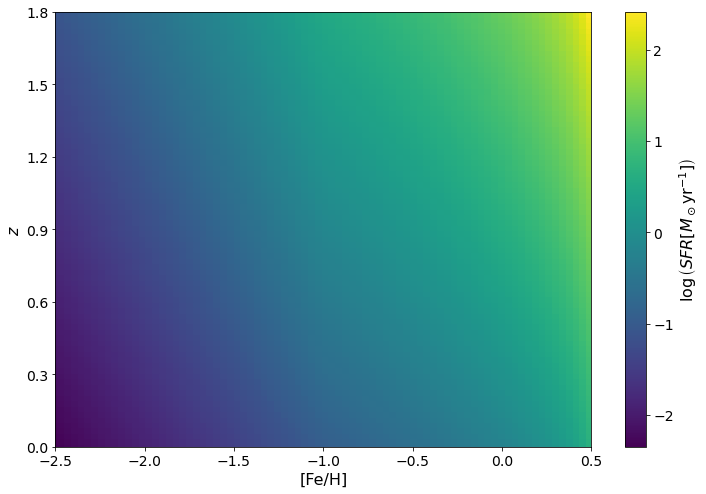

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
    
ax.scatter(xx, yy, c=correctedSFR, cmap='viridis', vmin=correctedSFR.min(), vmax=correctedSFR.max(), s=100, marker='s')
 
ax.set_ylabel(r'$z$', fontsize=16)
ax.set_xlabel('[Fe/H]', fontsize=16)

ax.set_ylim(0.01,1.8)
ax.set_xlim(-2.5, 0.5)

ax.tick_params(axis='both', labelsize=14)
    
ax.set_yticks(np.arange(0,1.9,0.3))
    
sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=correctedSFR.min(), vmax=correctedSFR.max()))
cb = fig.colorbar(sm)

cb.set_label(label=r'$\log\left(SFR[M_\odot\mathrm{yr}^{-1}]\right)$', size=16)
cb.ax.tick_params(labelsize=14)

#### Saving a grid file

Lastly, we need to save our results in a grid file that can be read by the IMF calculator in order to build our COMPAS grid. A simple text file with three columns (z, Z, SFR) is enough. The IMF doesn't depend explicitly on the redshift, but because the SFR does, we should keep track of it.